In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")

print("Path to dataset files:", path)

100%|██████████| 8.91k/8.91k [00:00<00:00, 2.97MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/uciml/pima-indians-diabetes-database/versions/1


In [11]:
import pandas as pd
path = "/root/.cache/kagglehub/datasets/uciml/pima-indians-diabetes-database/versions/1/diabetes.csv"
df = pd.read_csv(path)
# for column in df.columns[:-1]:
#     median_value = df[column].median()
#     df[column] = (df[column] > median_value).astype(int)

print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [ ]:
mean_value = df['Glucose'].mean()

print(mean_value)

120.89453125


In [ ]:
import pymc as pm
import pandas as pd
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
data = df

# Step 2: Separate the glucose levels into two groups
glucose_non_diabetic = data.loc[data['Outcome'] == 0, 'Glucose']
glucose_diabetic = data.loc[data['Outcome'] == 1, 'Glucose']

print(glucose_non_diabetic)

1       85
3       89
5      116
7      115
10     110
      ... 
762     89
763    101
764    122
765    121
767     93
Name: Glucose, Length: 500, dtype: int64


In [ ]:
glucose_non_diabetic.head()

,Glucose
1,85
3,89
5,116
7,115
10,110


Output()

Output()

               mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_0        110.026  1.149  107.903  112.164      0.014    0.010    7139.0   
mu_1        141.076  1.909  137.574  144.587      0.022    0.016    7429.0   
difference   31.050  2.259   26.921   35.303      0.025    0.018    8309.0   

            ess_tail  r_hat  
mu_0          3043.0    1.0  
mu_1          3236.0    1.0  
difference    3256.0    1.0  


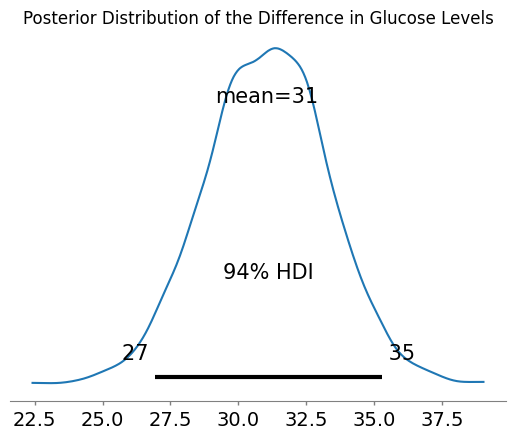

95% credible interval for the difference in means: <xarray.Dataset> Size: 64B
Dimensions:     (hdi: 2)
Coordinates:
  * hdi         (hdi) <U6 48B 'lower' 'higher'
Data variables:
    difference  (hdi) float64 16B 26.92 35.3


In [6]:
# Step 3: Define the Bayesian model
with pm.Model() as model:
    # Priors for group means and standard deviations
    mu_0 = pm.Normal("mu_0", mu=120, sigma=20)
    mu_1 = pm.Normal("mu_1", mu=120, sigma=20)
    sigma_0 = pm.HalfNormal("sigma_0", sigma=10)
    sigma_1 = pm.HalfNormal("sigma_1", sigma=10)

    # Likelihoods for each group
    obs_0 = pm.Normal("obs_0", mu=mu_0, sigma=sigma_0, observed=glucose_non_diabetic)
    obs_1 = pm.Normal("obs_1", mu=mu_1, sigma=sigma_1, observed=glucose_diabetic)

    # Difference in means
    diff = pm.Deterministic("difference", mu_1 - mu_0)

    # Posterior sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, random_seed=42)

# Step 4: Analyze the results
# Posterior summary
summary = az.summary(trace, var_names=["mu_0", "mu_1", "difference"])
print(summary)

# Visualize the posterior distribution of the difference
az.plot_posterior(trace, var_names=["difference"])
plt.title("Posterior Distribution of the Difference in Glucose Levels")
plt.show()

# Step 5: Interpret the credible interval
credible_interval = az.hdi(trace, var_names=["difference"])
print("95% credible interval for the difference in means:", credible_interval)


In [7]:
glucose_diabetic.mean()

141.25746268656715

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data
X = df.drop(columns=["Glucose", "Outcome"])  # Exclude 'Glucose' and 'Outcome'
y = df["Glucose"]  # Continuous response variable (Glucose)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the multiple regression model
multi_reg = LinearRegression()
multi_reg.fit(X_train, y_train)

# Predictions
y_pred = multi_reg.predict(X_test)

# Model Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R²: {r2}")


Mean Squared Error: 869.4777053181734
R²: 0.135973429426115


Mean Squared Error (MSE): 0.17104527280850101
R² (R-squared): 0.25500281176741757
Ridge Regression - MSE: 0.17100646965576663
Ridge Regression - R²: 0.2551718210548829
Lasso Regression - MSE: 0.18430487893995587
Lasso Regression - R²: 0.19724986061708094


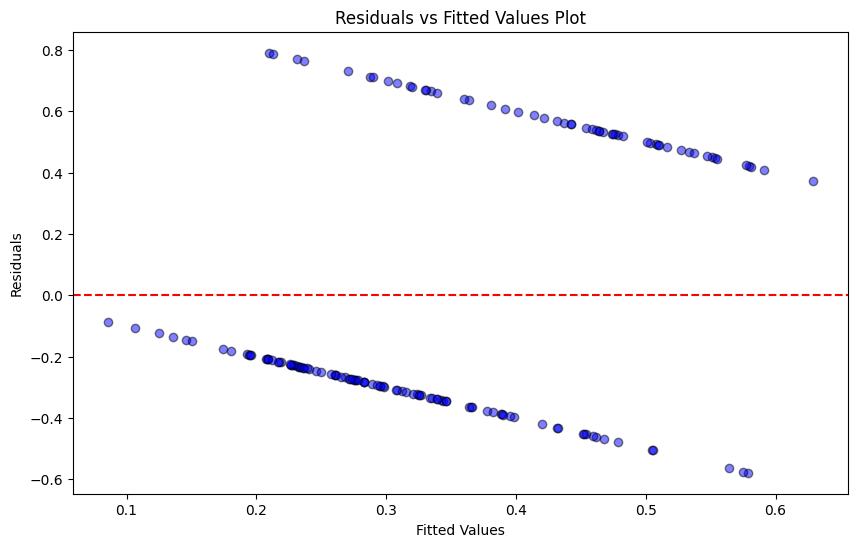

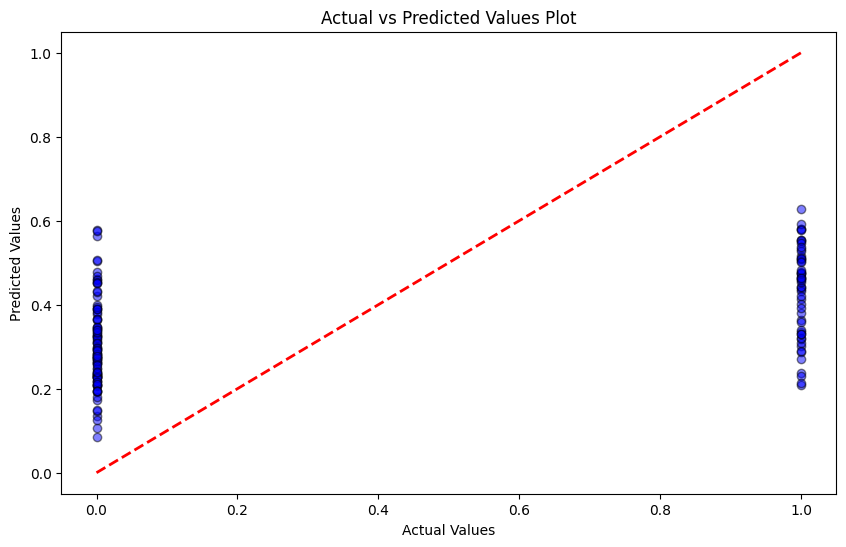

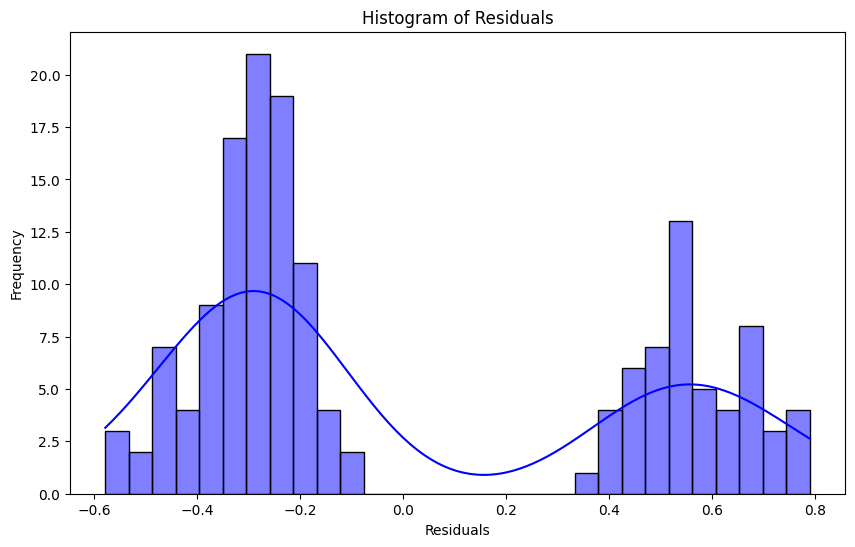

                          Coefficient
Pregnancies                  0.034681
Glucose                      0.179989
BloodPressure               -0.042015
SkinThickness                0.008131
Insulin                     -0.032086
BMI                          0.116137
DiabetesPedigreeFunction     0.037430
Age                          0.074168


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Load dataset (assume 'df' is the pandas DataFrame with Pima Indian Diabetes data)
data = df

# Step 1: Prepare the dataset
# Define features (X) and target variable (y)
X = data.drop(columns=['Outcome'])  # Exclude 'Outcome' for features
y = data['Outcome']  # 'Outcome' is the target variable

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Standardize the features (important for models like Ridge and Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Apply Multiple Linear Regression (Base Model)
multi_reg = LinearRegression()
multi_reg.fit(X_train_scaled, y_train)

# Step 5: Predict the outcomes
y_pred = multi_reg.predict(X_test_scaled)

# Step 6: Calculate the MSE and R² for the model
mse = mean_squared_error(y_test, y_pred)
r2 = multi_reg.score(X_test_scaled, y_test)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² (R-squared): {r2}")

# Step 7: Apply Ridge (L2 Regularization) or Lasso (L1 Regularization) to reduce MSE
# Ridge Regression
ridge_reg = Ridge(alpha=1.0)  # You can tune the alpha value
ridge_reg.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_reg.predict(X_test_scaled)

# Calculate MSE and R² for Ridge Regression
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = ridge_reg.score(X_test_scaled, y_test)
print(f"Ridge Regression - MSE: {mse_ridge}")
print(f"Ridge Regression - R²: {r2_ridge}")

# Lasso Regression (You can tune alpha to avoid overfitting)
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_reg.predict(X_test_scaled)

# Calculate MSE and R² for Lasso Regression
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = lasso_reg.score(X_test_scaled, y_test)
print(f"Lasso Regression - MSE: {mse_lasso}")
print(f"Lasso Regression - R²: {r2_lasso}")

# Step 8: Visualization - Residuals vs Fitted Values Plot
residuals = y_test - y_pred_lasso  # Use Lasso or Ridge predictions here
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_lasso, residuals, color='blue', edgecolors='k', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values Plot')
plt.show()

# Step 9: Visualization - Actual vs Predicted Values Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lasso, color='blue', edgecolors='k', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values Plot')
plt.show()

# Step 10: Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue', bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Step 11: Displaying the Coefficients from Ridge or Lasso
coefficients = pd.DataFrame(ridge_reg.coef_, X.columns, columns=['Coefficient'])  # Use lasso_reg.coef_ for Lasso
print(coefficients)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                Outcome   No. Observations:                  614
Model:                            GLM   Df Residuals:                      605
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -379.32
Date:                Sat, 30 Nov 2024   Deviance:                       332.63
Time:                        09:18:46   Pearson chi2:                     347.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1753
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3349      0.086    -15.571      0.0

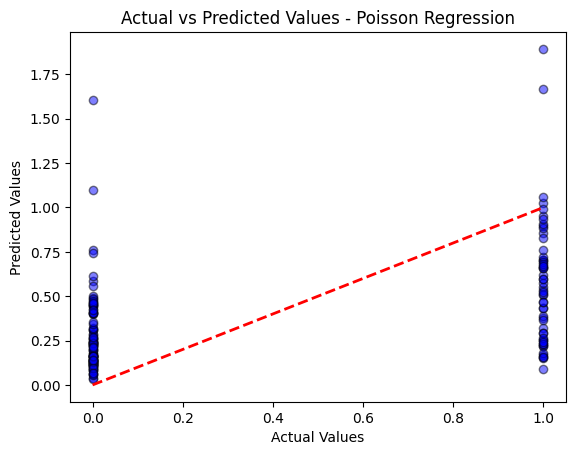

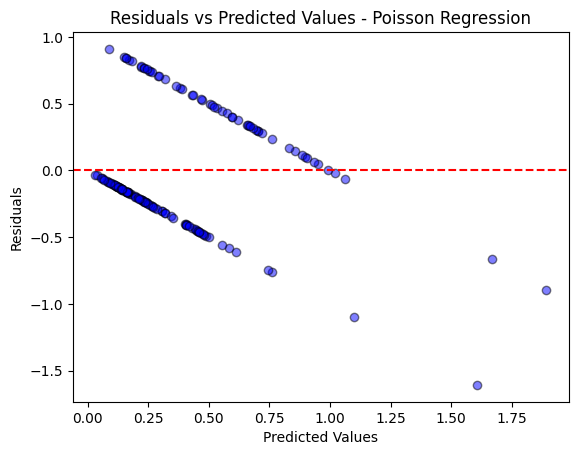

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (assuming df is the Pima Indian Diabetes dataset)
data = df

# Define features (X) and target variable (y)
X = data.drop(columns=['Outcome'])  # Exclude 'Outcome' for features
y = data['Outcome']  # 'Outcome' is the target variable (Poisson count data)

# Step 1: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Standardize the features (important for models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Add a constant to the features (for intercept term in Poisson regression)
X_train_scaled = sm.add_constant(X_train_scaled)  # Add constant for intercept
X_test_scaled = sm.add_constant(X_test_scaled)  # Add constant for intercept

# Step 4: Poisson Regression Model
poisson_model = sm.GLM(y_train, X_train_scaled, family=sm.families.Poisson()).fit()

# Step 5: Print the summary of the Poisson regression model
print(poisson_model.summary())

# Step 6: Predict on the test set
y_pred_poisson = poisson_model.predict(X_test_scaled)

# Step 7: Evaluate the model (Mean Squared Error, R²)
from sklearn.metrics import mean_squared_error, r2_score
mse_poisson = mean_squared_error(y_test, y_pred_poisson)
r2_poisson = r2_score(y_test, y_pred_poisson)

print(f"Poisson Regression - MSE: {mse_poisson}")
print(f"Poisson Regression - R²: {r2_poisson}")

# Step 8: Plot the Actual vs Predicted values
plt.scatter(y_test, y_pred_poisson, color='blue', edgecolors='k', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values - Poisson Regression')
plt.show()

# Step 9: Residuals Plot
residuals_poisson = y_test - y_pred_poisson
plt.scatter(y_pred_poisson, residuals_poisson, color='blue', edgecolors='k', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values - Poisson Regression')
plt.show()


Accuracy: 0.7532467532467533
Confusion Matrix:
[[79 20]
 [18 37]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81        99
           1       0.65      0.67      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154

ROC-AUC Score: 0.7353535353535354


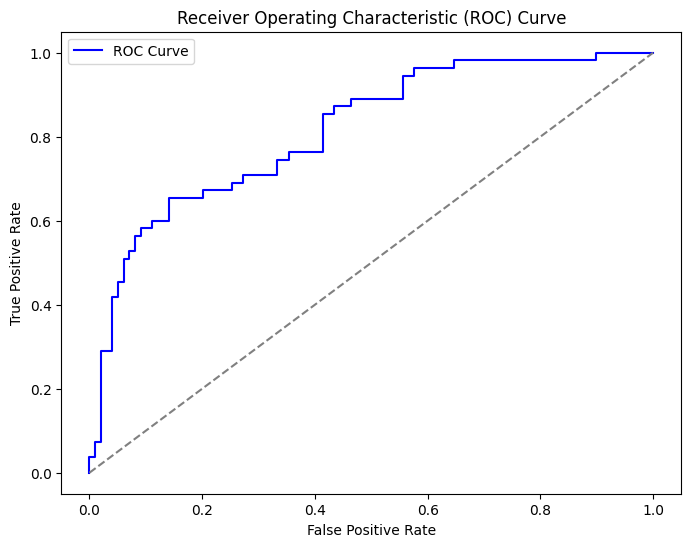

Logistic Regression Coefficients:
             Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  \
Coefficient     0.212554  1.071301      -0.247826       0.045729 -0.200783   

                  BMI  DiabetesPedigreeFunction       Age  
Coefficient  0.778182                  0.230625  0.421207  


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Load the dataset (assuming df is the Pima Indian Diabetes dataset)
data = df

# Define features (X) and target variable (y)
X = data.drop(columns=['Outcome'])  # Exclude 'Outcome' for features
y = data['Outcome']  # 'Outcome' is the target variable (0 or 1)

# Step 1: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Standardize the features (important for models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Logistic Regression Model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)

# Step 4: Predict on the test set
y_pred = logreg.predict(X_test_scaled)

# Step 5: Model Evaluation
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC Score: {roc_auc}")

# Step 6: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_scaled)[:,1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Step 7: Visualize the coefficients (feature importance)
coefficients = pd.DataFrame(logreg.coef_, columns=X.columns, index=['Coefficient'])
print("Logistic Regression Coefficients:")
print(coefficients)
